In [193]:
import sympy as sm
from sympy import diff, Symbol
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

In [194]:
from sympy.physics.vector import init_vprinting
init_vprinting(use_latex="mathjax", pretty_print=False)

In [195]:
from sympy.physics.mechanics import dynamicsymbols

In [196]:
m1, m2, l1, l2, gty ,tau1, tau2 = sm.symbols('m1 m2 l1 l2 g tau1 tau2', real =True)
theta1, theta2 = dynamicsymbols('theta1 theta2')
theta1d = dynamicsymbols('theta1',1)
theta2d = dynamicsymbols('theta2',1)
theta1dd = dynamicsymbols('theta1',2)
theta2dd = dynamicsymbols('theta2',2)
gty, m1, m2, l1, l2, theta1, theta2, theta1d, theta2d, theta1dd, theta2dd, tau1, tau2

(g, m1, m2, l1, l2, theta1, theta2, theta1', theta2', theta1'', theta2'', tau1, tau2)

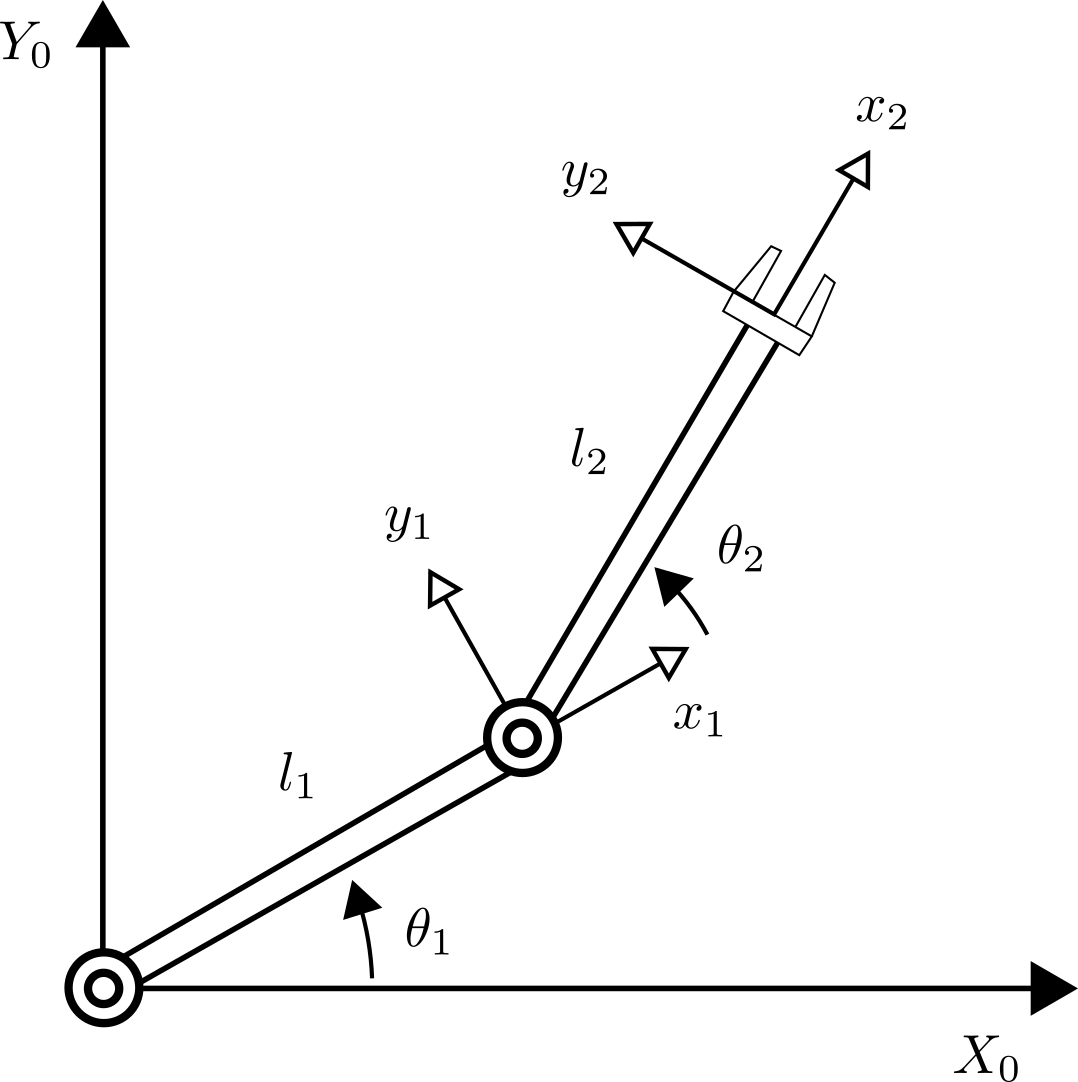

In [197]:
from IPython.display import Image
Image('fig/2rp_new.png', width=300)

In [198]:
x1 = l1*sm.cos(theta1)
y1 = l1*sm.sin(theta1)
x2 = l1*sm.cos(theta1) + l2*sm.cos(theta1 + theta2)
y2 = l1*sm.sin(theta1) + l2*sm.sin(theta1 + theta2)

x1_dot = sm.diff(x1,'t')
x2_dot = sm.diff(x2,'t')
y1_dot = sm.diff(y1,'t')
y2_dot = sm.diff(y2,'t')

x1_dot , x2_dot, y1_dot , y2_dot

(-l1*sin(theta1)*theta1', -l1*sin(theta1)*theta1' - l2*(theta1' + theta2')*sin(theta1 + theta2), l1*cos(theta1)*theta1', l1*cos(theta1)*theta1' + l2*(theta1' + theta2')*cos(theta1 + theta2))

In [199]:
# kinetic energy
ke = (sm.Rational(1/2))*m1*(x1_dot**2)
ke += (sm.Rational(1/2))*m1*(y1_dot**2)
ke += (sm.Rational(1/2))*m2*(x2_dot**2)
ke += (sm.Rational(1/2))*m2*(y2_dot**2)
sm.simplify(ke)

l1**2*m1*theta1'**2/2 + l1**2*m2*theta1'**2/2 + l1*l2*m2*cos(theta2)*theta1'**2 + l1*l2*m2*cos(theta2)*theta1'*theta2' + l2**2*m2*theta1'**2/2 + l2**2*m2*theta1'*theta2' + l2**2*m2*theta2'**2/2

In [200]:
# potential energy
pe = m1*gty*y1
pe += m2*gty*y2
sm.expand(pe)

g*l1*m1*sin(theta1) + g*l1*m2*sin(theta1) + g*l2*m2*sin(theta1 + theta2)

In [201]:
# the lagrangian equation
Ls = ke - pe

In [221]:
# force applied at joint 1
f1 = sm.diff(sm.diff(Ls,theta1d),Symbol('t')) - sm.diff(Ls,theta1)
f1sim = sm.expand(sm.simplify(f1))
f1sim

g*l1*m1*cos(theta1) + g*l1*m2*cos(theta1) + g*l2*m2*cos(theta1 + theta2) + l1**2*m1*theta1'' + l1**2*m2*theta1'' - 2*l1*l2*m2*sin(theta2)*theta1'*theta2' - l1*l2*m2*sin(theta2)*theta2'**2 + 2*l1*l2*m2*cos(theta2)*theta1'' + l1*l2*m2*cos(theta2)*theta2'' + l2**2*m2*theta1'' + l2**2*m2*theta2''

In [222]:
# force applied at joint 2
f2 = sm.diff(sm.diff(Ls,theta2d),Symbol('t')) - sm.diff(Ls,theta2)
f2sim = sm.expand(sm.simplify(f2))
f2sim

g*l2*m2*cos(theta1 + theta2) + l1*l2*m2*sin(theta2)*theta1'**2 + l1*l2*m2*cos(theta2)*theta1'' + l2**2*m2*theta1'' + l2**2*m2*theta2''

In [204]:
#inertia term
B11 = f1sim.coeff(theta1dd) * theta1dd
B12 = f2sim.coeff(theta1dd) * theta1dd

B21 = f1sim.coeff(theta2dd) * theta2dd
B22 = f2sim.coeff(theta2dd) * theta2dd

B = sm.Matrix([[B11, B21], [B12, B22]])
B

Matrix([
[(l1**2*m1 + l1**2*m2 + 2*l1*l2*m2*cos(theta2) + l2**2*m2)*theta1'', (l1*l2*m2*cos(theta2) + l2**2*m2)*theta2''],
[                        (l1*l2*m2*cos(theta2) + l2**2*m2)*theta1'',                          l2**2*m2*theta2'']])

In [205]:
#centrifugal / Coriolis force term,
C11 = (f1sim.coeff(theta1d * theta2d)*theta1d * theta2d) + (f1sim.coeff(theta1d * theta1d)* theta1d * theta1d) + (f1sim.coeff(theta2d * theta2d)*theta2d * theta2d)
C12 = (f2sim.coeff(theta1d * theta2d)*theta1d * theta2d) + (f2sim.coeff(theta1d * theta1d)* theta1d * theta1d) + (f2sim.coeff(theta2d * theta2d)*theta2d * theta2d)

C = sm.Matrix([C11, C12])
C

Matrix([
[-2*l1*l2*m2*sin(theta2)*theta1'*theta2' - l1*l2*m2*sin(theta2)*theta2'**2],
[                                          l1*l2*m2*sin(theta2)*theta1'**2]])

In [206]:
# gravity term
g1 = f1sim - sm.expand(B11) - sm.expand(B21) - sm.expand(C11)
g2 = f2sim - sm.expand(B12) - sm.expand(B22) - sm.expand(C12)
g = sm.Matrix([g1, g2])
g

Matrix([
[g*l1*m1*cos(theta1) + g*l1*m2*cos(theta1) + g*l2*m2*cos(theta1 + theta2)],
[                                            g*l2*m2*cos(theta1 + theta2)]])

In [207]:
# dynamic equations
dynamics_sol = sm.solve([(f1sim-tau1)  ,(f2sim-tau2) ],[theta1dd,theta2dd])
theta1dd_solver = dynamics_sol[theta1dd]
theta2dd_solver = dynamics_sol[theta2dd]

In [208]:
theta1dd_func = sm.lambdify([gty, m1, m2, l1, l2, theta1, theta2, theta1d, theta2d, tau1, tau2], theta1dd_solver)
theta2dd_func = sm.lambdify([gty, m1, m2, l1, l2, theta1, theta2, theta1d, theta2d, tau1, tau2], theta2dd_solver)
theta1d_func = sm.lambdify(theta1d, theta1d)
theta2d_func = sm.lambdify(theta2d, theta2d)

In [209]:
# ode func for scipy odeint
def dSdt(S,t, g, m1, m2, l1, l2, torq1, torq2):
    thet1, thet1d, thet2, thet2d = S
    return [
        theta1d_func(thet1d),
        theta1dd_func(g, m1, m2, l1, l2, thet1, thet2, thet1d, thet2d, torq1, torq2),
        theta2d_func(thet2d),
        theta2dd_func(g, m1, m2, l1, l2, thet1, thet2, thet1d, thet2d, torq1, torq2)
    ]

In [210]:
t = np.linspace(0, 40, 1001)
g = 0
m1 = 1
m2 = 1
l1 = 2
l2 = 2
tq1 = 1
tq2 = 0.2
ans = odeint(dSdt, y0=[0,0,0,0], t=t, args=(g, m1, m2, l1, l2, tq1, tq2))

In [211]:
ans.T

array([[ 0.00000000e+00,  1.19999990e-04,  4.79999816e-04, ...,
         4.31290707e+01,  4.32484886e+01,  4.33717436e+01],
       [ 0.00000000e+00,  5.99999944e-03,  1.19999930e-02, ...,
         2.93094675e+00,  3.03717114e+00,  3.12072909e+00],
       [ 0.00000000e+00, -1.99999970e-04, -7.99999506e-04, ...,
         3.66065998e-01,  2.70888111e-01,  1.64348889e-01],
       [ 0.00000000e+00, -9.99999851e-03, -1.99999814e-02, ...,
        -2.21660377e+00, -2.53336493e+00, -2.77849152e+00]])

In [212]:
the1 = ans.T[0]
the1d = ans.T[1]
the2 = ans.T[2]
the2d = ans.T[3]

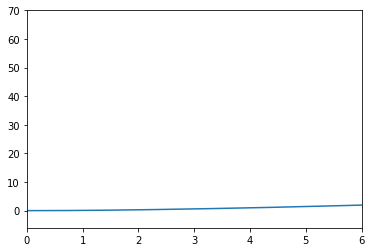

In [213]:
plt.axis([0, 6, -6, 70])
plt.plot(t, the1)

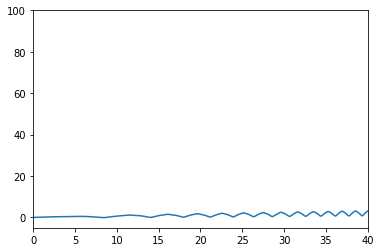

In [214]:
plt.axis([0, 40, -5, 100])
plt.plot(t, the1d)

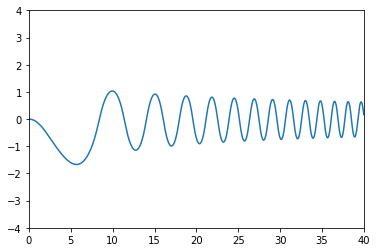

In [215]:
plt.axis([0, 40, -4, 4])
plt.plot(t, the2)

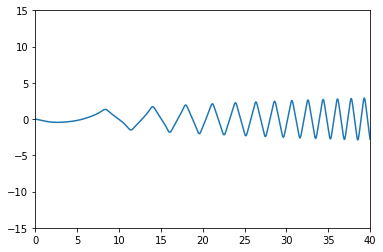

In [216]:
plt.axis([0, 40, -15, 15])
plt.plot(t, the2d)

In [217]:
def get_x1y1x2y2(t, the1, the2, d1, d2):
    return (d1*np.cos(the1),
            d1*np.sin(the1),
            d1*np.cos(the1) + d2*np.cos(the1+the2),
            d1*np.sin(the1) + d2*np.sin(the1+the2))


x1, y1, x2, y2 = get_x1y1x2y2(t, ans.T[0], ans.T[2], l1, l2)

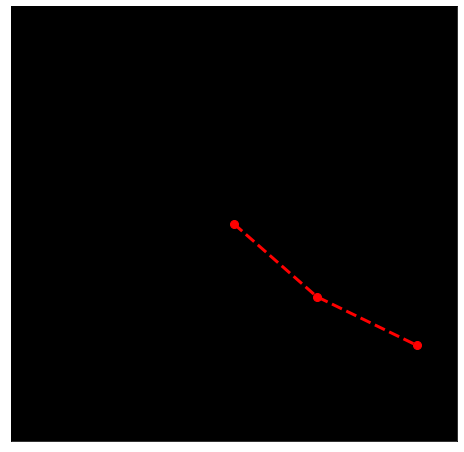

In [218]:
def animate(i):
    ln1.set_data([0, x1[i], x2[i]], [0, y1[i], y2[i]])
    
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.set_facecolor('k')
ax.get_xaxis().set_ticks([])    # enable this to hide x axis ticks
ax.get_yaxis().set_ticks([])    # enable this to hide y axis ticks
ln1, = plt.plot([], [], 'ro--', lw=3, markersize=8)
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('pen.gif',writer='pillow',fps=25)